In [1]:
import numpy as np
import pandas as pd
import os
import torch
from torch.utils.data import DataLoader,Dataset
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
base_dir = '/kaggle/input/flickr8k'
caption_file = base_dir + '/captions.txt'

df = pd.read_csv(caption_file)
print("There are {} image to captions".format(len(df)))
df.head(7)

There are 40455 image to captions


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image  # Load img
import matplotlib.image as mpimg


data_idx = 20 #0, 5, 10, 15...
    
image_path = base_dir + "/Images/" + df.iloc[data_idx,0]

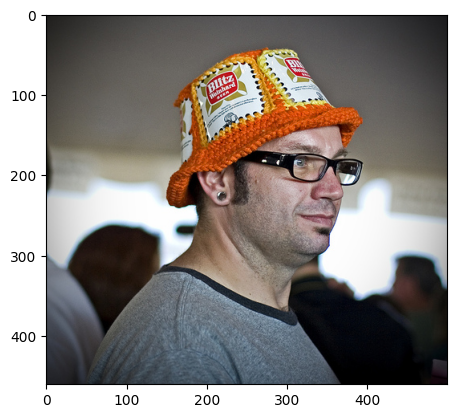

Caption: A man in an orange hat starring at something .
Caption: A man wears an orange hat and glasses .
Caption: A man with gauges and glasses is wearing a Blitz hat .
Caption: A man with glasses is wearing a beer can crocheted hat .
Caption: The man with pierced ears is wearing glasses and an orange hat .


In [4]:
from PIL import Image
img = Image.open(image_path)
plt.imshow(np.asarray(img))
plt.show()

for i in range(data_idx,data_idx+5):
    print("Caption:",df.iloc[i,1])

In [5]:
class Vocabulary:

    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    
    @staticmethod
    def tokenizer_eng(text):
        return [tok.lower() for tok in nltk.tokenize.word_tokenize(text)]

    
    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        
        for sentence in sentence_list:
            # tokenizer words
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1
                # words vocabulary
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    
    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [6]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

       
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

    
        self.vocab = Vocabulary(freq_threshold)
   
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)
        # SOS => start of sentence
        numericalized_caption = [self.vocab.stoi["<SOS>"]]

        numericalized_caption += self.vocab.numericalize(caption)
        # EOS => end of sentence
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        return img, torch.tensor(numericalized_caption)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim


In [8]:
# import torchvision.models as models weight
from torchvision.models import inception_v3, Inception_V3_Weights

class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
       
        self.inception = inception_v3(aux_logits=False,init_weights=Inception_V3_Weights.IMAGENET1K_V1)
        # embed_size，transfer learning
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        for name, param in self.inception.named_parameters():
            if "fc.weight" in name or "fc.bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
                
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.inception(images)
        return self.dropout(self.relu(features))

In [9]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        # encoder output feature 
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


In [10]:
class EncoderDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(EncoderDecoder, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
          
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                # RNN output state 
                hiddens, states = self.decoderRNN.lstm(x, states)
                # linear 
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                
                predicted = output.argmax(1)
                # result_caption
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)
                #token (<EOS>) 
                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]


In [11]:
from torch.nn.utils.rnn import pad_sequence 
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

In [12]:
import torchvision.transforms as transforms
# Inpection V3 model input 299 x 299
transform = transforms.Compose(
    [
        transforms.Resize((356, 356)),
        transforms.RandomCrop((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [13]:
dataset = FlickrDataset(
    root_dir = base_dir + "/Images", 
    captions_file = base_dir + '/captions.txt',
    transform=transform)

dataloader = DataLoader(dataset=dataset, 
                        batch_size=64, 
                        shuffle=True,
                        num_workers=4,
                        pin_memory=True,
                        collate_fn=MyCollate(pad_idx=dataset.vocab.stoi["<PAD>"]) 
                        )

In [14]:
#Hyperparams
embed_size = 256
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 1
learning_rate = 3e-4
num_epochs = 10
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [15]:
# initialize model, loss etc
model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
from tqdm import tqdm
model.train()

for epoch in range(num_epochs):
    for idx, (imgs, captions) in (pbar := tqdm(enumerate(dataloader), 
                                               total=len(dataloader))):
        imgs = imgs.to(device)
        captions = captions.to(device)

        outputs = model(imgs, captions[:-1])
        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f'epoch={epoch}, loss= {loss.item()}')

epoch=9, loss= 2.815045118331909: 100%|██████████| 633/633 [03:01<00:00,  3.48it/s] 


Caption: A brown and white dog is jumping up , with a stick in its mouth .


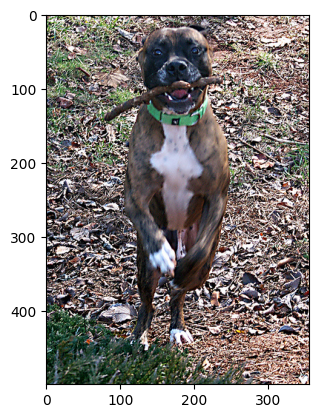

In [17]:
test_idx = 6000
test_img_file_path = f'{base_dir}/Images/{df.iloc[test_idx,0]}'
test_image = Image.open(test_img_file_path)#.show()
plt.imshow(np.asarray(test_image))

for i in range(test_idx,test_idx+1):
    print("Caption:",df.iloc[i,1])

In [18]:
test_transform = transforms.Compose(
    [
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [19]:
model.eval()
test_img = test_transform(test_image.convert("RGB")).unsqueeze(0)
caption = ' '.join(model.caption_image(test_img.to(device), dataset.vocab))
' answer: ', dataset.captions[test_idx]

(' answer: ',
 'A brown and white dog is jumping up , with a stick in its mouth .')

In [22]:
!pip install nltk


BLEU Score: 0.7763932022500211


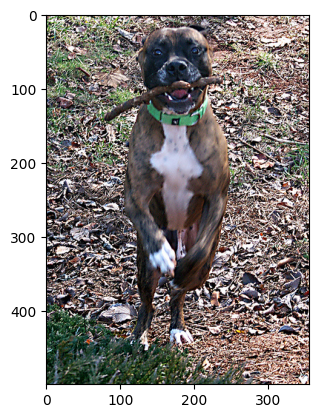

In [27]:
test_idx = 6000
test_img_file_path = f'{base_dir}/Images/{df.iloc[test_idx, 0]}'
test_image = Image.open(test_img_file_path)
plt.imshow(np.asarray(test_image))

# Generate caption for the test image
test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
model.eval()
test_img = test_transform(test_image.convert("RGB")).unsqueeze(0)
generated_text = ' '.join(model.caption_image(test_img.to(device), dataset.vocab))  # Define generated_text here

# Get reference captions (ground truth)
references = [
    [caption.split()]  # Split the ground truth caption into tokens
    for caption in df.iloc[test_idx:test_idx + 5, 1]  # Get the ground truth captions for the test image
]

# Create a list of the same generated caption for each reference
hypotheses = [
    generated_text.split()  # Split the generated caption into tokens
] * 5  # Repeat the generated caption 5 times to match the number of references

# Calculate BLEU score
from nltk.translate.bleu_score import corpus_bleu

bleu_score =1- corpus_bleu(references, hypotheses)
print("BLEU Score:", bleu_score)
